$$
\newcommand{\argmax}{arg\,max}
\newcommand{\argmin}{arg\,min}
$$

# The Aiyagari Model

# GPU

This lecture was built using a machine with access to a GPU.

[Google Colab](https://colab.research.google.com/) has a free tier with GPUs
that you can access as follows:

1. Click on the “play” icon top right  
1. Select Colab  
1. Set the runtime environment to include a GPU  

## Overview

In this lecture, we describe the structure of a class of models that build on work by Truman Bewley [[Bew77](https://python.quantecon.org/zreferences.html#id173)].

We begin by discussing an example of a Bewley model due to Rao Aiyagari [[Aiy94](https://python.quantecon.org/zreferences.html#id137)].

The model features

- Heterogeneous agents  
- A single exogenous vehicle for borrowing and lending  
- Limits on amounts individual agents may borrow  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94](https://python.quantecon.org/zreferences.html#id138)]  
- risk sharing and asset pricing [[HL96](https://python.quantecon.org/zreferences.html#id130)]  
- the shape of the wealth distribution [[BBZ15](https://python.quantecon.org/zreferences.html#id131)]  

### References

The primary reference for this lecture is [[Aiy94](https://python.quantecon.org/zreferences.html#id138)].

A textbook treatment is available in chapter 18 of [[LS18](https://python.quantecon.org/zreferences.html#id183)].

A less sophisticated version of this lecture (without JAX) can be found
[here](https://python.quantecon.org/aiyagari.html).

### Preliminaries

We use the following imports

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from collections import namedtuple

Let’s check the GPU we are running

In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


We will use 64 bit floats with JAX in order to increase the precision.

In [3]:
jax.config.update("jax_enable_x64", True)

We will use the following function to compute stationary distributions of stochastic matrices.  (For a reference to the algorithm, see p. 88 of [Economic Dynamics](https://johnstachurski.net/edtc).)

In [4]:
@jax.jit
def compute_stationary(P):
    n = P.shape[0]
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))

## Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y = A K^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
\max_{K, N} \left\{ A K^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

These parameters are stored in the following namedtuple.

In [5]:
Firm = namedtuple('Firm', ('A', 'N', 'α', 'δ'))

def create_firm(A=1.0,
                N=1.0,
                α=0.33,
                δ=0.05):
    """
    Create a namedtuple that stores firm data.
    
    """
    return Firm(A=A, N=N, α=α, δ=δ)

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{18.1}
$$

In [6]:
def r_given_k(K, firm):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    A, N, α, δ = firm
    return A * α * (N / K)**(1 - α) - δ

Using [(18.1)](#equation-equation-aiy-rgk) and the firm’s first-order condition for labor,


<a id='equation-equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{18.2}
$$

In [7]:
def r_to_w(r, firm):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    A, N, α, δ = firm
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

## Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

In this simple version of the model, households supply labor  inelastically because they do not value leisure.

Below we provide code to solve the household problem, taking $ r $ and $ w $ as fixed.

### Primitives and Operators

We will solve the household problem using Howard policy iteration
(see Ch 5 of [Dynamic Programming](https://dp.quantecon.org/)).

First we set up a namedtuple to store the parameters that define a household asset
accumulation problem, as well as the grids used to solve it.

In [8]:
Household = namedtuple('Household', 
                       ('β', 'a_grid', 'z_grid', 'Π'))

In [9]:
def create_household(β=0.96,                      # Discount factor
                     Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                     z_grid=[0.1, 1.0],           # Exogenous states
                     a_min=1e-10, a_max=20,       # Asset grid
                     a_size=200):
    """
    Create a namedtuple that stores all data needed to solve the household
    problem, given prices.

    """
    a_grid = jnp.linspace(a_min, a_max, a_size)
    z_grid, Π = map(jnp.array, (z_grid, Π))
    return Household(β=β, a_grid=a_grid, z_grid=z_grid, Π=Π)

For now we assume that $ u(c) = \log(c) $.

(CRRA utility is treated in the exercises.)

In [10]:
u = jnp.log

Here’s a tuple that stores the wage rate and interest rate, as well as a function that creates a price namedtuple with default values.

In [11]:
Prices = namedtuple('Prices', ('r', 'w'))

def create_prices(r=0.01,   # Interest rate
                  w=1.0):   # Wages
    return Prices(r=r, w=w)

Now we set up a vectorized version of the right-hand side of the Bellman equation
(before maximization), which is a 3D array representing

$$
B(a, z, a') = u(wz + (1+r)a - a') + \beta \sum_{z'} v(a', z') Π(z, z')
$$

for all $ (a, z, a') $.

In [12]:
@jax.jit
def B(v, household, prices):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w * z + (1 + r) * a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))  # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=-1)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + β * EV, -jnp.inf)

The next function computes greedy policies.

In [13]:
@jax.jit
def get_greedy(v, household, prices):
    """
    Computes a v-greedy policy σ, returned as a set of indices.  If 
    σ[i, j] equals ip, then a_grid[ip] is the maximizer at i, j.

    """
    return jnp.argmax(B(v, household, prices), axis=-1) # argmax over ap

The following function computes the array $ r_{\sigma} $ which gives current
rewards given policy $ \sigma $.

In [14]:
@jax.jit
def compute_r_σ(σ, household, prices):
    """
    Compute current rewards at each i, j under policy σ.  In particular,

        r_σ[i, j] = u((1 + r)a[i] + wz[j] - a'[ip])

    when ip = σ[i, j].

    """
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r) * a + w * z - ap
    r_σ = u(c)

    return r_σ

The value $ v_{\sigma} $ of a policy $ \sigma $ is defined as

$$
v_{\sigma} = (I - \beta P_{\sigma})^{-1} r_{\sigma}
$$

(See Ch 5 of [Dynamic Programming](https://dp.quantecon.org/) for notation and background on Howard policy iteration.)

To compute this vector, we set up the linear map $ v \rightarrow R_{\sigma} v $, where $ R_{\sigma} := I - \beta P_{\sigma} $.

This map can be expressed as

$$
(R_{\sigma} v)(a, z) = v(a, z) - \beta \sum_{z'} v(\sigma(a, z), z') Π(z, z')
$$

(Notice that $ R_\sigma $ is expressed as a linear operator rather than a matrix – this is much easier and cleaner to code, and also exploits sparsity.)

In [15]:
@jax.jit
def R_σ(v, σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]
    
    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))
    
    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * jnp.sum(V * Π, axis=-1)

The next function computes the lifetime value of a given policy.

In [16]:
@jax.jit
def get_value(σ, household, prices):
    """
    Get the lifetime value of policy σ by computing

        v_σ = R_σ^{-1} r_σ

    """
    r_σ = compute_r_σ(σ, household, prices)
    # Reduce R_σ to a function in v
    _R_σ = lambda v: R_σ(v, σ, household)
    # Compute v_σ = R_σ^{-1} r_σ using an iterative routing.
    return jax.scipy.sparse.linalg.bicgstab(_R_σ, r_σ)[0]

Here’s the Howard policy iteration.

In [17]:
def howard_policy_iteration(household, prices,
                            tol=1e-4, max_iter=10_000, verbose=False):
    """
    Howard policy iteration routine.

    """
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    σ = jnp.zeros((a_size, z_size), dtype=int)
    
    v_σ = get_value(σ, household, prices)
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        σ_new = get_greedy(v_σ, household, prices)
        v_σ_new = get_value(σ_new, household, prices)
        error = jnp.max(jnp.abs(v_σ_new - v_σ))
        σ = σ_new
        v_σ = v_σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    return σ

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices.

In [18]:
# Create an instance of Household
household = create_household()
prices = create_prices()

In [19]:
r, w = prices

In [20]:
r, w

(0.01, 1.0)

In [21]:
%time σ_star = howard_policy_iteration(household, prices, verbose=True)

Concluded loop 1 with error 11.366778025479089.
Concluded loop 2 with error 9.574633288044097.
Concluded loop 3 with error 3.9654259495145783.
Concluded loop 4 with error 1.1207182505726303.
Concluded loop 5 with error 0.2523956110337373.
Concluded loop 6 with error 0.12172293204340434.
Concluded loop 7 with error 0.04339669259701573.
Concluded loop 8 with error 0.012131201439755657.
Concluded loop 9 with error 0.005822894713963578.
Concluded loop 10 with error 0.0028616670739296524.
Concluded loop 11 with error 0.001666591157166053.
Concluded loop 12 with error 0.00041536611388215405.
Concluded loop 13 with error 0.0.
CPU times: user 804 ms, sys: 59.7 ms, total: 864 ms
Wall time: 482 ms


The next plot shows asset accumulation policies at different values of the exogenous state.

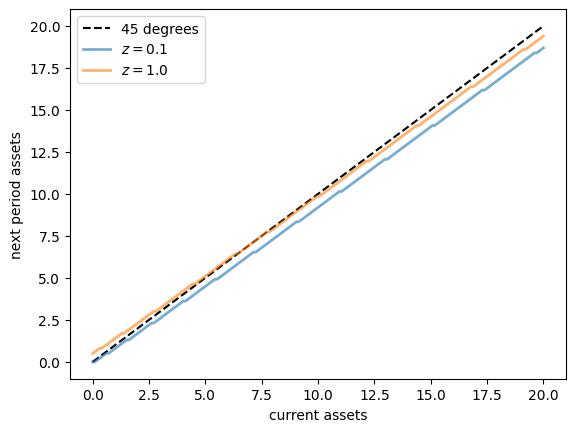

In [22]:
β, a_grid, z_grid, Π = household

fig, ax = plt.subplots()
ax.plot(a_grid, a_grid, 'k--', label="45 degrees")  
for j, z in enumerate(z_grid):
    lb = f'$z = {z:.2}$'
    policy_vals = a_grid[σ_star[:, j]]
    ax.plot(a_grid, policy_vals, lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

### Capital Supply

To start thinking about equilibrium, we need to know how much capital households supply at a given interest rate $ r $.

This quantity can be calculated by taking the stationary distribution of assets under the optimal policy and computing the mean.

The next function computes the stationary distribution for a given policy $ \sigma $ via the following steps:

- compute the stationary distribution $ \psi = (\psi(a, z)) $ of $ P_{\sigma} $, which defines the
  Markov chain of the state $ (a_t, z_t) $ under policy $ \sigma $.  
- sum out $ z_t $ to get the marginal distribution for $ a_t $.  

In [23]:
@jax.jit
def compute_asset_stationary(σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

Let’s give this a test run.

In [24]:
ψ_a = compute_asset_stationary(σ_star, household)

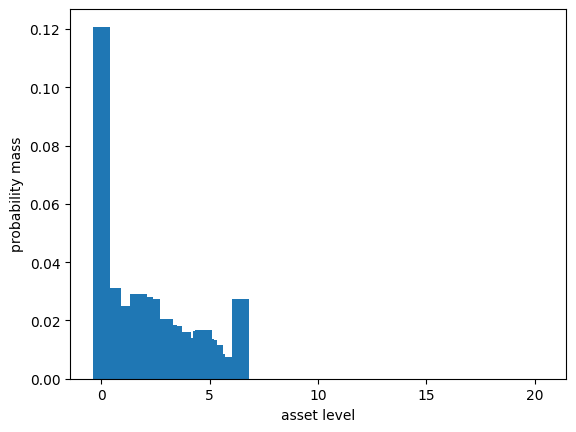

In [25]:
fig, ax = plt.subplots()
ax.bar(household.a_grid, ψ_a)
ax.set_xlabel("asset level")
ax.set_ylabel("probability mass")
plt.show()

The distribution should sum to one:

In [26]:
ψ_a.sum()

Array(1., dtype=float64)

The next function computes aggregate capital supply by households under policy $ \sigma $, given wages and interest rates.

In [27]:
def capital_supply(σ, household):
    """
    Induced level of capital stock under the policy, taking r and w as given.
    
    """
    β, a_grid, z_grid, Π = household
    ψ_a = compute_asset_stationary(σ, household)
    return float(jnp.sum(ψ_a * a_grid))

## Equilibrium

We compute a **stationary rational expectations equilibrium** (SREE) as follows:

1. set $ n=0 $, start with initial guess $ K_0 $ for aggregate capital  
1. determine prices $ r, w $ from the firm decision problem, given $ K_n $  
1. compute the optimal savings policy of the households given these prices  
1. compute aggregate capital $ K_{n+1} $ as the mean of steady state capital given this savings policy  
1. if $ K_{n+1} \approx K_n $ stop, otherwise go to step 2.  


We can write the sequence of operations in steps 2-4 as

$$
K_{n + 1} = G(K_n)
$$

If $ K_{n+1} $ agrees with $ K_n $ then we have a SREE.

In other words, our problem is to find the fixed-point of the one-dimensional map $ G $.

Here’s $ G $ expressed as a Python function:

In [28]:
def G(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)
    # Generate a household object with these prices, compute
    # aggregate capital.
    prices = create_prices(r=r, w=w)
    σ_star = howard_policy_iteration(household, prices)
    return capital_supply(σ_star, household)

### Visual inspection

Let’s inspect visually as a first pass.

In [29]:
num_points = 50
firm = create_firm()
household = create_household()
k_vals = np.linspace(4, 12, num_points)
out = [G(k, firm, household) for k in k_vals]

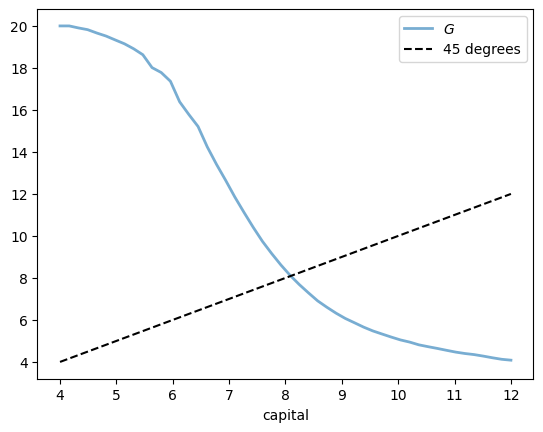

In [30]:
fig, ax = plt.subplots()
ax.plot(k_vals, out, lw=2, alpha=0.6, label='$G$')
ax.plot(k_vals, k_vals, 'k--', label="45 degrees")
ax.set_xlabel('capital')
ax.legend()
plt.show()

### Computing the equilibrium

Now let’s compute the equilibrium.

Looking at the figure above, we see that a simple iteration scheme $ K_{n+1} = G(K_n) $ will cycle from high to low values, leading to slow convergence.

As a result, we use a damped iteration scheme of the form

$$
K_{n+1} = \alpha K_n + (1-\alpha) G(K_n)
$$

In [31]:
def compute_equilibrium(firm, household,
                        K0=6, α=0.99, max_iter=1_000, tol=1e-4, 
                        print_skip=10, verbose=False):
    n = 0
    K = K0
    error = tol + 1
    while error > tol and n < max_iter:
        new_K = α * K + (1 - α) * G(K, firm, household)
        error = abs(new_K - K)
        K = new_K
        n += 1
        if verbose and n % print_skip == 0:
            print(f"At iteration {n} with error {error}")
    return K, n

In [32]:
firm = create_firm()
household = create_household()
print("\nComputing equilibrium capital stock")
start = time.time()
K_star, n = compute_equilibrium(firm, household, K0=6.0, verbose=True)
elapsed = time.time() - start
print(f"Computed equilibrium {K_star:.5} in {n} iterations and {elapsed} seconds")


Computing equilibrium capital stock
At iteration 10 with error 0.06490545798846181
At iteration 20 with error 0.03626685465746515
At iteration 30 with error 0.02145270368256913
At iteration 40 with error 0.013383829253183599
At iteration 50 with error 0.008397515264348954
At iteration 60 with error 0.005656370053091386
At iteration 70 with error 0.0037501078199406734
At iteration 80 with error 0.00248162109564376
At iteration 90 with error 0.0017352118526261506
At iteration 100 with error 0.0009559876840974368
At iteration 110 with error 0.0006843412659662818
At iteration 120 with error 0.00046762845635406336
At iteration 130 with error 0.0003819310101480511
At iteration 140 with error 0.0001942162681753956
At iteration 150 with error 0.00017041810888507314
At iteration 160 with error 0.0001541230829325002
At iteration 170 with error 0.00013938615354902595
Computed equilibrium 8.0918 in 176 iterations and 11.90880560874939 seconds


This is not very fast, given how quickly we can solve the household problem.

You can try varying $ \alpha $, but usually this parameter is hard to set a priori.

In the exercises below you will be asked to use bisection instead, which generally performs better.

### Computing the equilibrium (MODIFIED)

Now let’s compute the equilibrium using Bayesian optimization

In [33]:
import gpjax as gpx
from scipy.stats import norm


def expected_improvement(mu, sigma, y_best, xi=0.01):
    """
    Computes Expected Improvement acquisition function.
    
    Args:
        mu: Predicted means at test points
        sigma: Predicted standard deviations
        y_best: Best observed value so far
        xi: Exploration parameter
    
    Returns:
        Expected improvement values
    """
    improvement = mu - y_best - xi
    Z = improvement / (sigma + 1e-9)  # Add small constant to avoid division by zero
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei


def compute_equilibrium_bo(firm, household, bounds=(6.0, 10.0), n_iter=10, 
                          seed=42, return_history=False):
    """
    Solves for Aiyagari equilibrium using Bayesian Optimization with GPJax.
    Minimizes squared difference between K and G(K).

    Args:
        firm, household: Model parameters
        bounds: Tuple (min_k, max_k) search space
        n_iter: Number of BO iterations
        seed: Random seed
        return_history: If True, return (K_star, history)

    Returns:
        K_star: Equilibrium capital stock
        history: (optional) List of dicts with GP state at each iteration
    """
    key = jax.random.PRNGKey(seed)
    
    # Objective: negative squared error (we maximize this)
    def objective(k):
        k_supply = G(k, firm, household)
        return -float((k_supply - k)**2)
    
    # Initialize with 3 points
    X_sample = jnp.array([[bounds[0]], [(bounds[0] + bounds[1])/2], [bounds[1]]])
    Y_sample = jnp.array([[objective(x[0])] for x in X_sample])
    
    # Setup GP with RBF kernel
    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    
    history = []
    print(f"Starting Bayesian Optimization with {n_iter} iterations...")
    
    for i in range(n_iter):
        key, subkey = jax.random.split(key)
        
        # Create dataset and likelihood
        D = gpx.Dataset(X=X_sample, y=Y_sample)
        # Use very small observation noise since our function is deterministic
        likelihood = gpx.likelihoods.Gaussian(
            num_datapoints=D.n, 
            obs_stddev=jnp.array(1e-6)
        )
        posterior = prior * likelihood
        
        # Fit GP hyperparameters
        opt_posterior, _ = gpx.fit_scipy(
            model=posterior,
            objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
            train_data=D,
        )
        
        # Predict on grid - use latent distribution (without observation noise) for BO
        X_grid = jnp.linspace(bounds[0], bounds[1], 1000).reshape(-1, 1)
        latent_dist = opt_posterior.predict(X_grid, train_data=D)
        mu = latent_dist.mean
        sigma = jnp.sqrt(latent_dist.variance)
        
        # Compute Expected Improvement
        y_best = jnp.max(Y_sample)
        ei = expected_improvement(mu, sigma, y_best)
        
        # Select next point
        next_idx = jnp.argmax(ei)
        next_k = X_grid[next_idx]
        
        # Store history
        if return_history:
            history.append({
                'iter': i + 1,
                'X_sample': np.array(X_sample),
                'Y_sample': np.array(Y_sample),
                'X_grid': np.array(X_grid),
                'mu': np.array(mu.flatten()),
                'sigma': np.array(sigma.flatten()),
                'ei': np.array(ei.flatten()),
                'next_k': np.array(next_k)
            })
        
        # Evaluate objective
        next_y = objective(next_k[0])
        print(f"Iter {i+1}: K={float(next_k[0]):.4f} | Squared Error={-next_y:.2e}")
        
        # Update dataset
        X_sample = jnp.vstack([X_sample, next_k])
        Y_sample = jnp.vstack([Y_sample, jnp.array([[next_y]])])
        
        # Check convergence
        if -next_y < 1e-6:
            print("Converged!")
            break
    
    # Return best K
    best_idx = jnp.argmax(Y_sample)
    K_star = float(X_sample[best_idx, 0])
    
    print(f"\nEquilibrium Capital: {K_star:.5f}")
    
    if return_history:
        return K_star, history
    return K_star

In [34]:
firm = create_firm()
household = create_household()
print("\nComputing equilibrium using Bayesian Optimization")
start = time.time()
K_star = compute_equilibrium_bo(firm, household)
elapsed = time.time() - start
print(f"Computed equilibrium in {elapsed:.2f} seconds")


Computing equilibrium using Bayesian Optimization
Starting Bayesian Optimization with 10 iterations...
Optimization terminated successfully.
         Current function value: 17.157526
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Iter 1: K=6.0040 | Squared Error=1.25e+02
Optimization terminated successfully.
         Current function value: 16.955419
         Iterations: 53
         Function evaluations: 64
         Gradient evaluations: 64
Iter 2: K=8.5826 | Squared Error=2.85e+00
Optimization terminated successfully.
         Current function value: 20.115077
         Iterations: 52
         Function evaluations: 69
         Gradient evaluations: 69
Iter 3: K=8.1742 | Squared Error=9.82e-02
Optimization terminated successfully.
         Current function value: 21.556211
         Iterations: 47
         Function evaluations: 58
         Gradient evaluations: 58
Iter 4: K=8.0901 | Squared Error=2.18e-04
Optimization terminated successfully

/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 7.556282
         Iterations: 42
         Function evaluations: 89
         Gradient evaluations: 79
Iter 7: K=8.0901 | Squared Error=2.18e-04


/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 1.711356
         Iterations: 46
         Function evaluations: 115
         Gradient evaluations: 102
Iter 8: K=8.0901 | Squared Error=2.18e-04


/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.165859
         Iterations: 47
         Function evaluations: 97
         Gradient evaluations: 87
Iter 9: K=8.0901 | Squared Error=2.18e-04


/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -10.063494
         Iterations: 46
         Function evaluations: 75
         Gradient evaluations: 65
Iter 10: K=8.0901 | Squared Error=2.18e-04

Equilibrium Capital: 8.09009
Computed equilibrium in 17.97 seconds


In [35]:
def plot_bo_iteration(history_snapshot, firm, household, ax=None):
    """
    Plot a single iteration of Bayesian Optimization.
    Shows GP mean, uncertainty, observed points, and next point to sample.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    X_grid = history_snapshot['X_grid'].flatten()
    mu = history_snapshot['mu'].flatten()
    sigma = history_snapshot['sigma'].flatten()
    X_sample = history_snapshot['X_sample'].flatten()
    Y_sample = history_snapshot['Y_sample'].flatten()
    next_k = history_snapshot['next_k'][0]
    
    # Plot GP mean and uncertainty
    ax.plot(X_grid, mu, 'b-', label='GP mean', linewidth=2)
    ax.fill_between(X_grid, mu - 1.96*sigma, mu + 1.96*sigma, 
                     alpha=0.2, color='blue', label='95% confidence')
    
    # Plot observed points
    ax.scatter(X_sample[:-1], Y_sample[:-1], c='red', s=100, zorder=10, 
               marker='o', edgecolors='k', label='Observed points')
    
    # Highlight the most recent point
    if len(X_sample) > 3:  # More than initial points
        ax.scatter(X_sample[-1], Y_sample[-1], c='orange', s=150, zorder=11,
                   marker='*', edgecolors='k', label='Latest point')
    
    # Show next point to sample
    ax.axvline(next_k, color='green', linestyle='--', linewidth=2, 
               label=f'Next sample: K={next_k:.3f}')
    
    ax.set_xlabel('Capital (K)', fontsize=12)
    ax.set_ylabel('Negative Squared Error', fontsize=12)
    ax.set_title(f"Iteration {history_snapshot['iter']}: GP Surrogate Model", fontsize=14)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return ax


def plot_bo_sequence(history, iterations_to_plot=None, firm=None, household=None):
    """
    Plot a sequence of BO iterations showing how the GP evolves.
    
    Args:
        history: List of history snapshots from compute_equilibrium_bo
        iterations_to_plot: List of iteration numbers to plot (default: [1, 3, 5, 7])
        firm, household: Model parameters (optional, for computing true function)
    """
    if iterations_to_plot is None:
        # Default: plot first, middle, and last few iterations
        n = len(history)
        if n <= 4:
            iterations_to_plot = list(range(1, n+1))
        else:
            iterations_to_plot = [1, max(2, n//3), max(3, 2*n//3), n]
    
    n_plots = len(iterations_to_plot)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, iter_num in enumerate(iterations_to_plot):
        if idx >= 4:  # Max 4 subplots
            break
        snapshot = history[iter_num - 1]
        plot_bo_iteration(snapshot, firm, household, ax=axes[idx])
    
    # Hide unused subplots
    for idx in range(n_plots, 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig


def plot_bo_with_acquisition(history_snapshot, firm, household):
    """
    Plot GP surrogate and acquisition function side by side.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    X_grid = history_snapshot['X_grid'].flatten()
    mu = history_snapshot['mu'].flatten()
    sigma = history_snapshot['sigma'].flatten()
    ei = history_snapshot['ei'].flatten()
    X_sample = history_snapshot['X_sample'].flatten()
    Y_sample = history_snapshot['Y_sample'].flatten()
    next_k = history_snapshot['next_k'][0]
    
    # Top plot: GP surrogate
    ax1.plot(X_grid, mu, 'b-', label='GP mean', linewidth=2)
    ax1.fill_between(X_grid, mu - 1.96*sigma, mu + 1.96*sigma, 
                     alpha=0.2, color='blue', label='95% confidence')
    ax1.scatter(X_sample, Y_sample, c='red', s=100, zorder=10, 
                marker='o', edgecolors='k', label='Observed')
    ax1.axvline(next_k, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax1.set_ylabel('Objective Value', fontsize=12)
    ax1.set_title(f"Iteration {history_snapshot['iter']}: Gaussian Process Surrogate", 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Acquisition function
    ax2.plot(X_grid, ei, 'g-', linewidth=2, label='Expected Improvement')
    ax2.fill_between(X_grid, 0, ei, alpha=0.3, color='green')
    ax2.axvline(next_k, color='green', linestyle='--', linewidth=2, 
                label=f'Next: K={next_k:.3f}')
    ax2.scatter([next_k], [ei.max()], c='green', s=200, zorder=10, 
                marker='*', edgecolors='k')
    ax2.set_xlabel('Capital (K)', fontsize=12)
    ax2.set_ylabel('Expected Improvement', fontsize=12)
    ax2.set_title('Acquisition Function (Where to Sample Next)', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

### Visualizing the Bayesian Optimization Process

Now let's visualize how Bayesian optimization explores the search space and converges to the equilibrium.

In [36]:
# Run Bayesian optimization with history tracking
firm = create_firm()
household = create_household()

print("Running Bayesian Optimization with history tracking...\n")
K_star, history = compute_equilibrium_bo(firm, household, n_iter=10, return_history=True)

Running Bayesian Optimization with history tracking...

Starting Bayesian Optimization with 10 iterations...
Optimization terminated successfully.
         Current function value: 17.157526
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Iter 1: K=6.0040 | Squared Error=1.25e+02
Optimization terminated successfully.
         Current function value: 16.955419
         Iterations: 53
         Function evaluations: 64
         Gradient evaluations: 64
Iter 2: K=8.5826 | Squared Error=2.85e+00
Optimization terminated successfully.
         Current function value: 20.115077
         Iterations: 52
         Function evaluations: 69
         Gradient evaluations: 69
Iter 3: K=8.1742 | Squared Error=9.82e-02
Optimization terminated successfully.
         Current function value: 21.556211
         Iterations: 47
         Function evaluations: 58
         Gradient evaluations: 58
Iter 4: K=8.0901 | Squared Error=2.18e-04
Optimization terminated success

/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 7.556282
         Iterations: 42
         Function evaluations: 89
         Gradient evaluations: 79
Iter 7: K=8.0901 | Squared Error=2.18e-04


/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 1.711356
         Iterations: 46
         Function evaluations: 115
         Gradient evaluations: 102
Iter 8: K=8.0901 | Squared Error=2.18e-04


/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.165859
         Iterations: 47
         Function evaluations: 97
         Gradient evaluations: 87
Iter 9: K=8.0901 | Squared Error=2.18e-04
         Current function value: -10.063494
         Iterations: 46
         Function evaluations: 75
         Gradient evaluations: 65
Iter 10: K=8.0901 | Squared Error=2.18e-04

Equilibrium Capital: 8.09009


/home/chase/quantecon/imf_2025/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:779: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


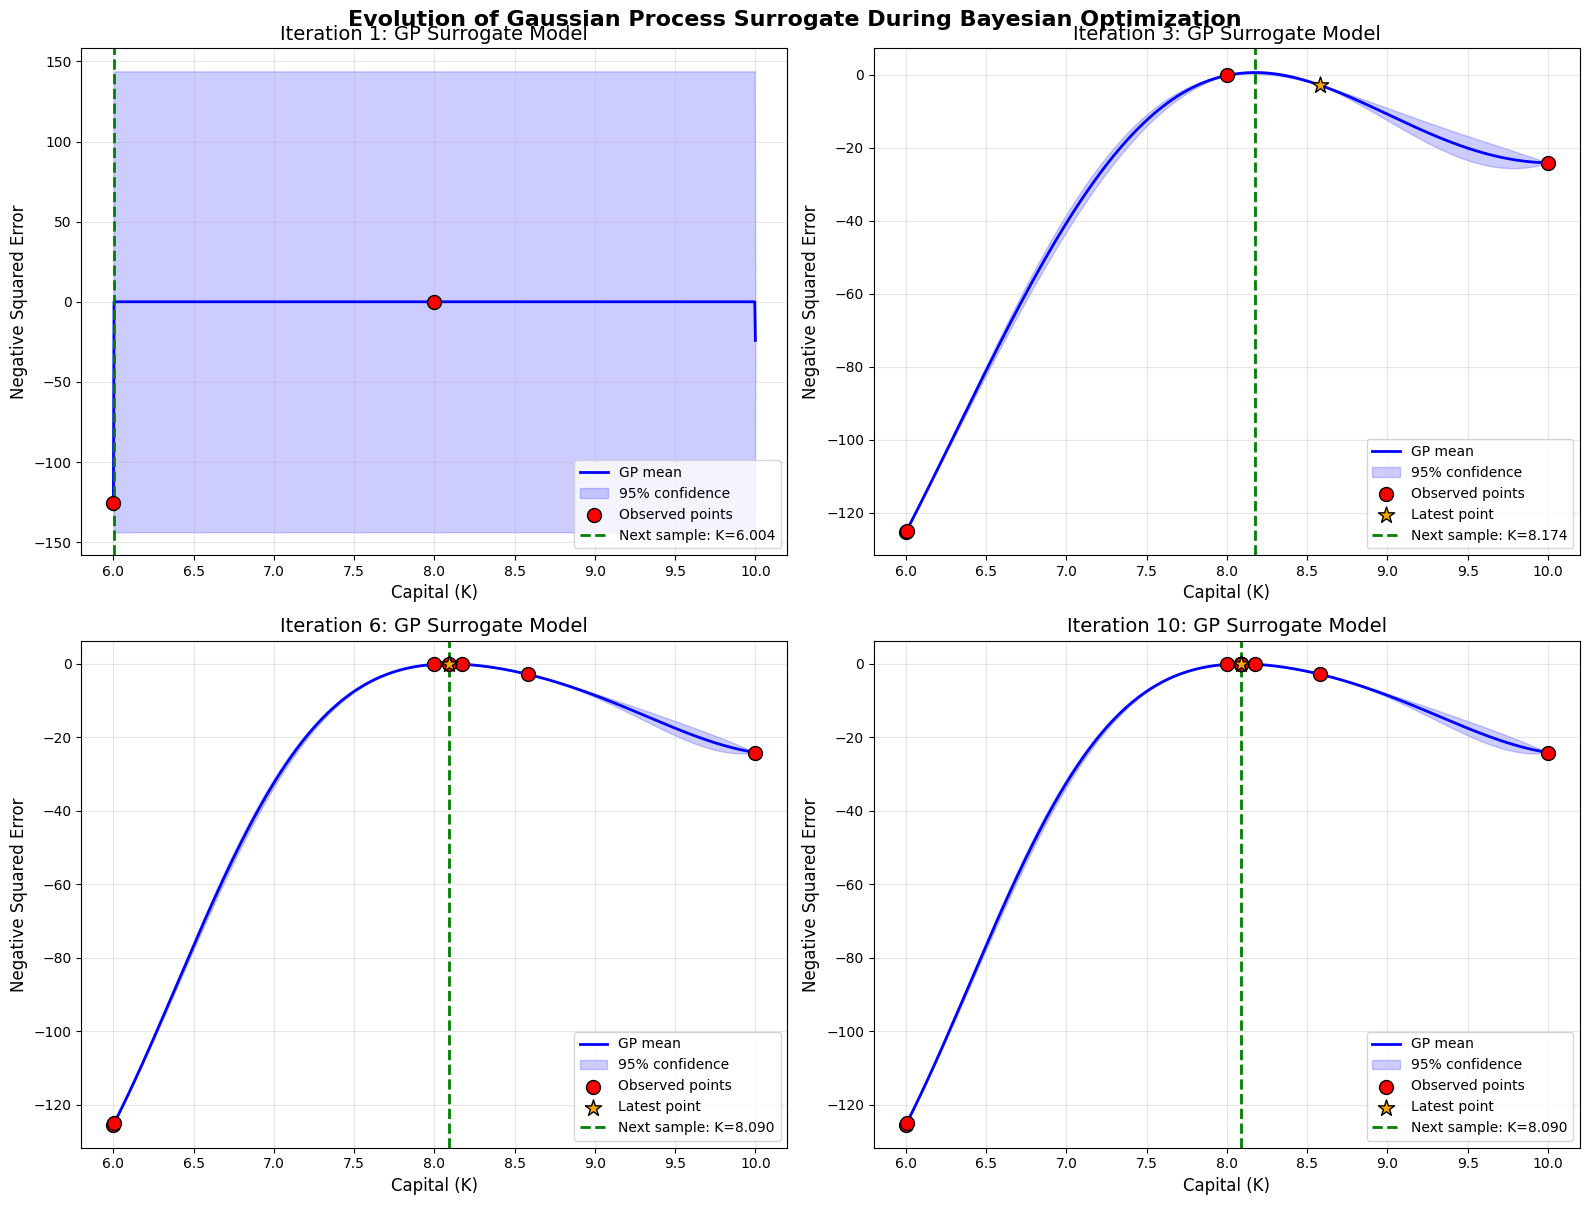

In [37]:
# Plot the evolution of the GP surrogate over iterations
plot_bo_sequence(history, iterations_to_plot=[1, 3, 6, 10])
plt.suptitle('Evolution of Gaussian Process Surrogate During Bayesian Optimization', 
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

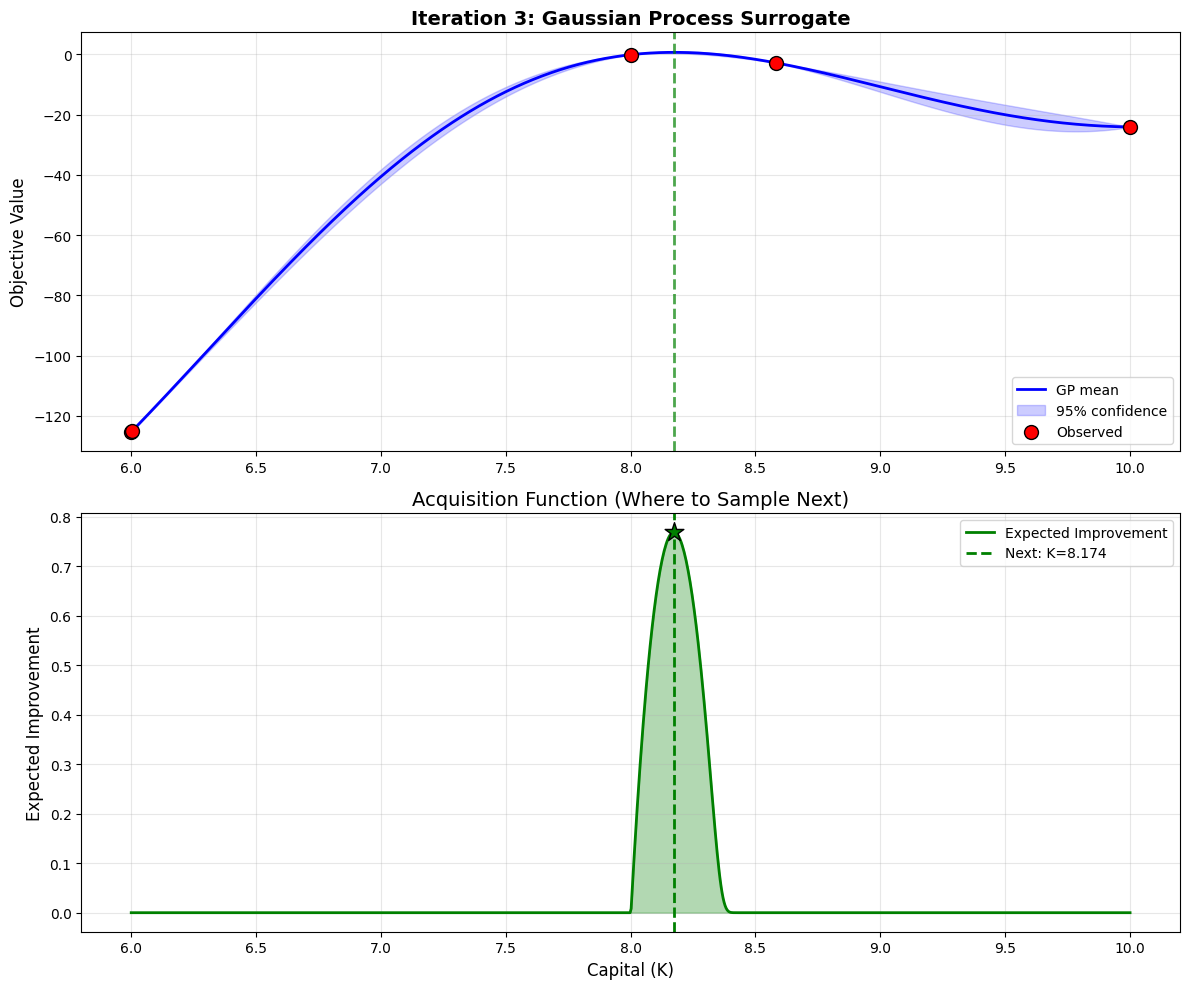

In [38]:
# Show GP and acquisition function together for a specific iteration
plot_bo_with_acquisition(history[2], firm, household)  # Show iteration 3
plt.show()

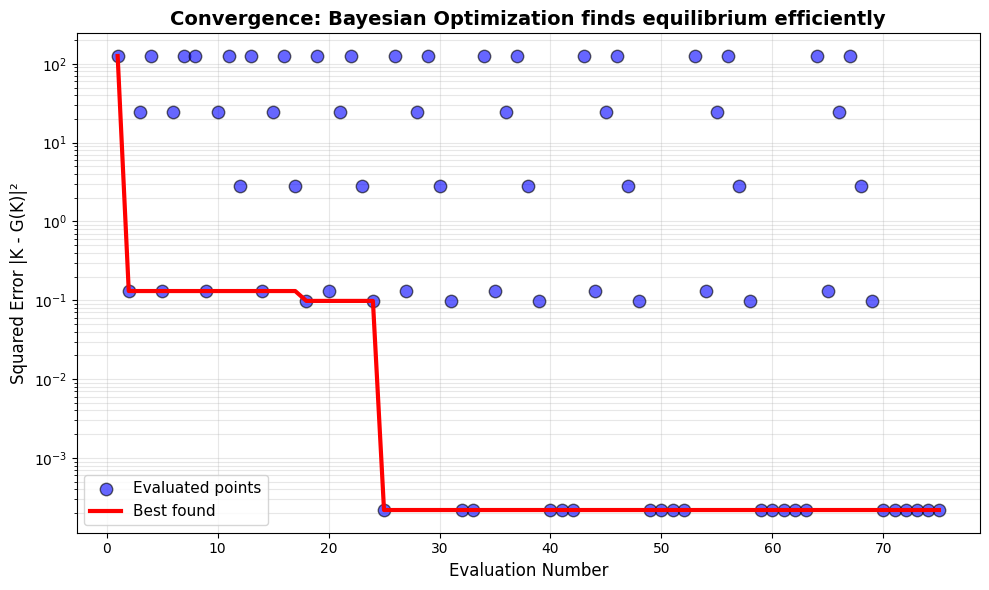

Final squared error: 2.18e-04
Equilibrium found at K = 8.09009


In [39]:
# Plot convergence: how the squared error decreases over iterations
fig, ax = plt.subplots(figsize=(10, 6))

# Extract all observed points across iterations
all_squared_errors = []
for h in history:
    # Convert back from negative squared error
    errors = -h['Y_sample'].flatten()
    all_squared_errors.extend(errors)

# Keep only unique points (remove duplicates from history tracking)
iterations = list(range(1, len(all_squared_errors) + 1))
cumulative_best = [min(all_squared_errors[:i+1]) for i in range(len(all_squared_errors))]

ax.scatter(iterations, all_squared_errors, c='blue', s=80, alpha=0.6, 
           label='Evaluated points', zorder=5, edgecolors='k')
ax.plot(iterations, cumulative_best, 'r-', linewidth=3, 
        label='Best found', zorder=10)
ax.set_xlabel('Evaluation Number', fontsize=12)
ax.set_ylabel('Squared Error |K - G(K)|²', fontsize=12)
ax.set_title('Convergence: Bayesian Optimization finds equilibrium efficiently', 
             fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

print(f"Final squared error: {cumulative_best[-1]:.2e}")
print(f"Equilibrium found at K = {K_star:.5f}")

### Understanding the Visualization

The plots above illustrate how Bayesian Optimization efficiently searches for the equilibrium:

1. **GP Surrogate Evolution**: The 2×2 grid shows how the Gaussian Process model learns the objective function over iterations. Notice how:
   - The uncertainty (blue shaded region) decreases where we've sampled
   - The GP mean (blue line) becomes more accurate over time
   - Green dashed lines show where we'll sample next

2. **Acquisition Function**: Shows how Expected Improvement balances:
   - **Exploitation**: Sampling near the current best
   - **Exploration**: Sampling in uncertain regions
   
3. **Convergence Plot**: Demonstrates that Bayesian Optimization finds the equilibrium with very few function evaluations (typically < 15), compared to hundreds needed by damped iteration.

The key advantage: each evaluation of `G(K)` requires solving the full household problem, so minimizing evaluations saves substantial computational time.

## Exercises

## Exercise 18.1

Write a new version of `compute_equilibrium` that uses `bisect` from `scipy.optimize` instead of damped iteration.

See if you can make it faster that the previous version.

In `bisect`,

- you should set `xtol=1e-4` to have the same error tolerance as the previous version.  
- for the lower and upper bounds of the bisection routine try `a = 1.0` and `b = 20.0`.  

## Solution to[ Exercise 18.1](https://jax.quantecon.org/#aiyagari-ex1)

In [ ]:
from scipy.optimize import bisect

We use bisection to find the zero of the function $ h(k) = k - G(k) $.

In [ ]:
def compute_equilibrium(firm, household, a=1.0, b=20.0):
    K = bisect(lambda k: k - G(k, firm, household), a, b, xtol=1e-4)
    return K

In [ ]:
firm = create_firm()
household = create_household()
print("\nComputing equilibrium capital stock")
start = time.time()
K_star = compute_equilibrium(firm, household)
elapsed = time.time() - start
print(f"Computed equilibrium capital stock {K_star:.5} in {elapsed} seconds")

Bisection seems to be faster than the damped iteration scheme.

## Exercise 18.2

Show how equilibrium capital stock changes with $ \beta $.

Use the following values of $ \beta $ and plot the relationship you find.

In [ ]:
β_vals = np.linspace(0.94, 0.98, 20)

## Solution to[ Exercise 18.2](https://jax.quantecon.org/#aiyagari-ex2)

In [ ]:
K_vals = np.empty_like(β_vals)
K = 6.0  # initial guess

for i, β in enumerate(β_vals):
    household = create_household(β=β)
    K = compute_equilibrium(firm, household, 0.5 * K, 1.5 * K)
    print(f"Computed equilibrium {K:.4} at β = {β}")
    K_vals[i] = K

In [ ]:
fig, ax = plt.subplots()
ax.plot(β_vals, K_vals, ms=2)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('capital')
plt.show()